# AUTO ARIMA MODEL FOR ENERGY CONSUMPTION & PREDICTION OF FUTURE ENERGY CONSUMPTION

In [15]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import os
from datetime import datetime
import plotly.express as px

from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import warnings

warnings.filterwarnings('ignore')
sns.set()

In [16]:
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')

In [22]:
# timeStamp feature is of type object, however, it should be changed to datetime64[ns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [23]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [25]:
df.head()

timeStamp  demand  precip   temp
0 2012-01-01 00:00:00  4937.5     0.0  46.13
1 2012-01-01 01:00:00  4752.1     0.0  45.89
2 2012-01-01 02:00:00  4542.6     0.0  45.04
3 2012-01-01 03:00:00  4357.7     0.0  45.03
4 2012-01-01 04:00:00  4275.5     0.0  42.61

In [58]:
# Add slider to the figure, buttons for 
fig = px.line(df, x='timeStamp', y='demand', title= 'NYC Energy Demand')
fig.update_xaxes(
    rangeslider_visible = True, 
    rangeselector = dict(
        buttons = list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="3y", step="year", stepmode="backward"),
                dict(count=3, label="5y", step="year", stepmode="backward"),
                dict(step = "all")
        ])
    )
)

fig.show()

In [61]:
ny_df = df.set_index('timeStamp')
ny_df

demand  precip   temp
timeStamp                                 
2012-01-01 00:00:00  4937.5  0.0000  46.13
2012-01-01 01:00:00  4752.1  0.0000  45.89
2012-01-01 02:00:00  4542.6  0.0000  45.04
2012-01-01 03:00:00  4357.7  0.0000  45.03
2012-01-01 04:00:00  4275.5  0.0000  42.61
...                     ...     ...    ...
2017-08-12 02:00:00     NaN  0.0000  70.84
2017-08-12 03:00:00     NaN  0.0000  70.57
2017-08-12 04:00:00     NaN  0.0000  69.89
2017-08-12 05:00:00     NaN  0.0000  68.59
2017-08-12 06:00:00     NaN  0.0031  67.33

[49205 rows x 3 columns]

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

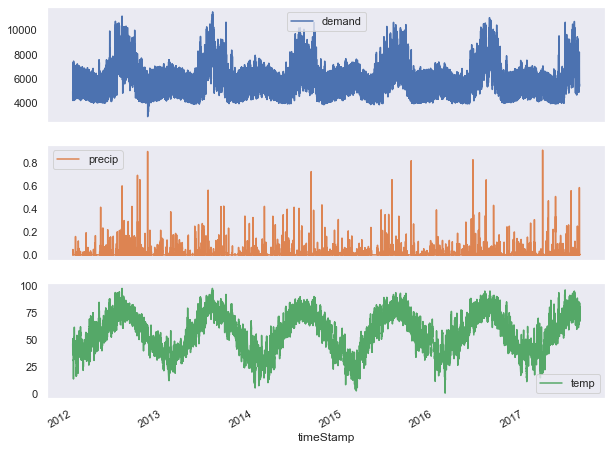

In [82]:
ny_df.plot(subplots = True)

In [65]:
print("Rows : ", df.shape[0])
print("Columns : ", df.shape[1])
print("\nFeatures : ", df.columns.tolist())
print("\nMissing Values : ", df.isnull().any())
print("\nUnique : ", df.nunique())

Rows :  49205
Columns :  4

Features :  ['timeStamp', 'demand', 'precip', 'temp']

Missing Values :  timeStamp    False
demand        True
precip        True
temp          True
dtype: bool

Unique :  timeStamp    49205
demand       40972
precip        1004
temp          7580
dtype: int64


In [70]:
df.isnull()

timeStamp  demand  precip   temp
0          False   False   False  False
1          False   False   False  False
2          False   False   False  False
3          False   False   False  False
4          False   False   False  False
...          ...     ...     ...    ...
49200      False    True   False  False
49201      False    True   False  False
49202      False    True   False  False
49203      False    True   False  False
49204      False    True   False  False

[49205 rows x 4 columns]

In [79]:
#index of the null value
#np.where(df['demand'].isnull())
df.query('demand!= demand') # shows only those rows which has null values 

timeStamp  demand  precip   temp
49124 2012-03-11 02:00:00     NaN  0.0000  37.78
49125 2013-03-10 02:00:00     NaN  0.0000  38.18
49126 2014-03-09 02:00:00     NaN  0.0000  40.86
49127 2015-03-08 02:00:00     NaN  0.0000  36.96
49128 2015-03-11 11:00:00     NaN  0.0000  49.95
...                   ...     ...     ...    ...
49200 2017-08-12 02:00:00     NaN  0.0000  70.84
49201 2017-08-12 03:00:00     NaN  0.0000  70.57
49202 2017-08-12 04:00:00     NaN  0.0000  69.89
49203 2017-08-12 05:00:00     NaN  0.0000  68.59
49204 2017-08-12 06:00:00     NaN  0.0031  67.33

[81 rows x 4 columns]

In [80]:
df['demand'] = df['demand'].fillna(method ='ffill')
df['temp'] = df['temp'].fillna(method ='ffill')

In [81]:
print("Missing Value : ", df.isnull().any())

Missing Value :  timeStamp    False
demand       False
precip        True
temp         False
dtype: bool


array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

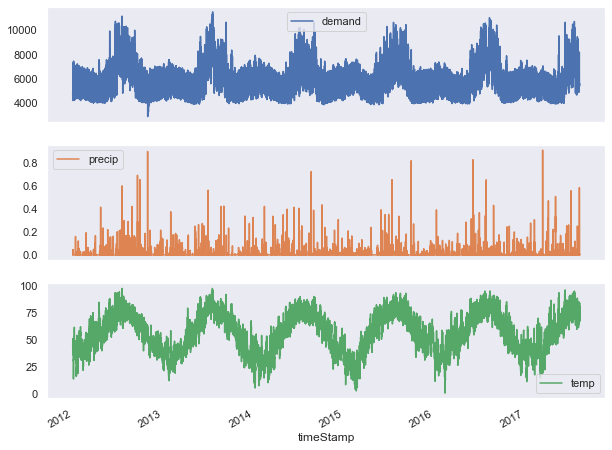

In [83]:
ny_df = df.set_index('timeStamp')
ny_df.plot(subplots = True)

In [88]:
# compress the date level data to monthlevel 
ny_monthly = ny_df.resample('M').mean()

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

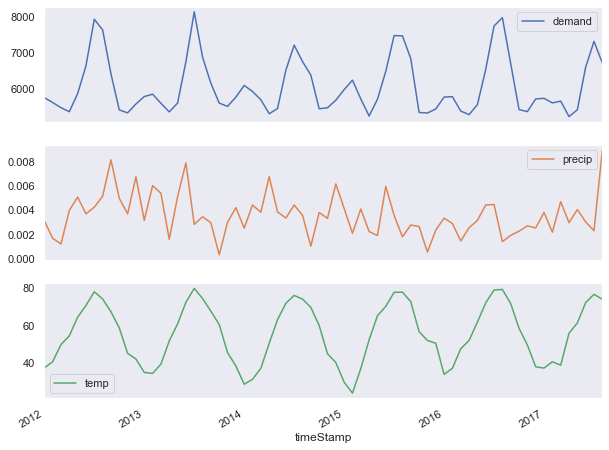

In [90]:
ny_monthly.plot(subplots = True)

In [93]:
#!pip install pmdarima
import pmdarima as pmd

In [104]:
#adf - Augmented Dickey füller test, checks the stationary data, if not then adf determines the difference
# stepwise - True, random grid search for PDQ combinations. If false then, tries all combinations of PDQ which is 
# time taking

model = pmd.auto_arima(ny_monthly['demand'], 
               m = 12, seasonal = True, 
               start_p = 0, start_q = 0, max_order = 4, test = 'adf', error_action = 'ignore', 
               suppress_warnings = True, 
              stepwise = True, trace =True)


# ARIMA(0,0,0) is the PDQ values, x(1,0,1) is the seasonal parameter it has its own PDQ parameters
# 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1100.321, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1023.740, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1380.758, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1065.516, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1022.940, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1097.636, Time=0.25 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1015.654, Time=0.59 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1014.060, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1021.211, Time=0.05 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=99

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -490.572
Date:                                 Sat, 05 Jun 2021   AIC                            993.144
Time:                                         14:07:01   BIC                           1006.461
Sample:                                              0   HQIC                           998.420
                                                  - 68                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3721.6223    792.261      4.697      0.000    2168.819    5274.425
ar.L1          0.8586      0.123      6.985      0.000       0.618       1.099
ar.L2         -0.4748      0.142     -3.352      0.001      -0.752      -0.197
ma.S.L12       0.8923      0.137      6.501      0.000       0.623       1.161
ma.S.L24       0.4571      0.206      2.222      0.026       0.054       0.860
sigma2      9.046e+04   1.58e+04      5.726      0.000    5.95e+04    1.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.55
Prob(Q):                              0.89   Prob(JB):                         0.06
Heteroskedasticity (H):               0.78   Skew:                             0.52
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
ny_monthly

demand    precip       temp
timeStamp                                   
2012-01-31  5757.495833  0.003116  37.174288
2012-02-29  5622.331609  0.001650  40.448046
2012-03-31  5479.919198  0.001179  49.607917
2012-04-30  5368.945833  0.003959  54.255903
2012-05-31  5867.896102  0.005064  64.188078
...                 ...       ...        ...
2017-04-30  5233.477382  0.002942  55.621764
2017-05-31  5421.773060  0.004031  61.115457
2017-06-30  6597.990346  0.003008  71.962625
2017-07-31  7306.861511  0.002272  76.380363
2017-08-31  6711.707542  0.008961  73.730258

[68 rows x 3 columns]

In [121]:
train = ny_monthly[(ny_monthly.index.get_level_values(0) >= '2012-01-31') & (ny_monthly.index.get_level_values(0) <= '2017-04-30')]

test = ny_monthly[ (ny_monthly.index.get_level_values(0) > '2017-04-30') ]

In [122]:
test.shape

(4, 3)

In [123]:
test

demand    precip       temp
timeStamp                                   
2017-05-31  5421.773060  0.004031  61.115457
2017-06-30  6597.990346  0.003008  71.962625
2017-07-31  7306.861511  0.002272  76.380363
2017-08-31  6711.707542  0.008961  73.730258

In [124]:
model.fit(train['demand'])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [125]:
# conf_int = confidence interval, its diffivult to predict accurate forcast, therefore an interval range is needed
forecast = model.predict(n_periods = 4, return_conf_int = True)

In [127]:
# first row is a forcast value, 
# second matrix is the confidence interval(lower, higher)
forecast

(array([5320.83279743, 6194.15060275, 7184.10809864, 7297.99960963]),
 array([[4724.37020264, 5917.29539222],
        [5391.43559507, 6996.86561042],
        [6358.61989427, 8009.59630302],
        [6467.74931856, 8128.24990069]]))

In [128]:
forcast_df = pd.DataFrame(forecast[0], index= test.index, columns= ['Prediciton'])

In [129]:
forcast_df

Prediciton
timeStamp              
2017-05-31  5320.832797
2017-06-30  6194.150603
2017-07-31  7184.108099
2017-08-31  7297.999610

<AxesSubplot:xlabel='timeStamp'>

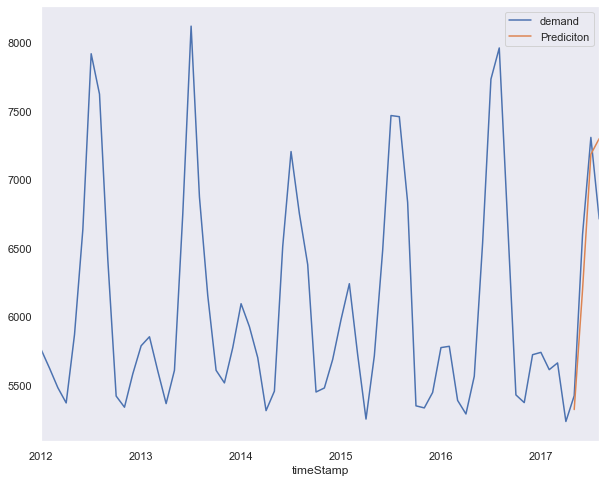

In [131]:
pd.concat([ny_monthly['demand'], forcast_df], axis=1).plot()

In [132]:
forecast_1 = model.predict(n_periods=8, return_conf_int= True) 

In [133]:
forecast_1

(array([5320.83279743, 6194.15060275, 7184.10809864, 7297.99960963,
        6401.92730231, 5789.92422772, 5693.03966487, 5951.57311614]),
 array([[4724.37020264, 5917.29539222],
        [5391.43559507, 6996.86561042],
        [6358.61989427, 8009.59630302],
        [6467.74931856, 8128.24990069],
        [5553.64731528, 7250.20728934],
        [4934.10752222, 6645.74093321],
        [4837.08540285, 6548.99392689],
        [5094.94721984, 6808.19901244]]))

In [138]:
forcast_range = pd.date_range(start = '2017-05-31', periods=8, freq= 'M')

In [139]:
forcast1_df = pd.DataFrame(forecast_1[0], index = forcast_range, columns= ['Prediction'])

<AxesSubplot:xlabel='timeStamp'>

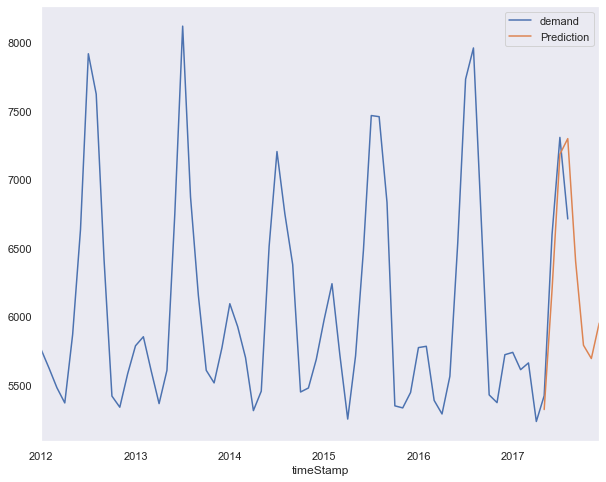

In [140]:
pd.concat([ny_monthly['demand'], forcast1_df], axis=1).plot()

In [142]:
lower_bound = pd.Series(forecast_1[1][:,0], index= forcast_range)
upper_bound = pd.Series(forecast_1[1][:,1], index= forcast_range)

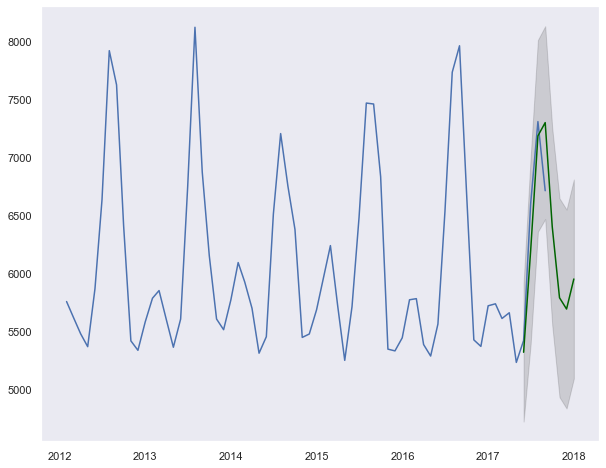

In [144]:
plt.plot(ny_monthly['demand'])
plt.plot(forcast1_df, color= 'darkgreen')
plt.fill_between(forecast_range, lower_bound, upper_bound, color='k',alpha= .15)

# Green is the actual forcast value 
# Grey value is the upper bound and lower bound range 

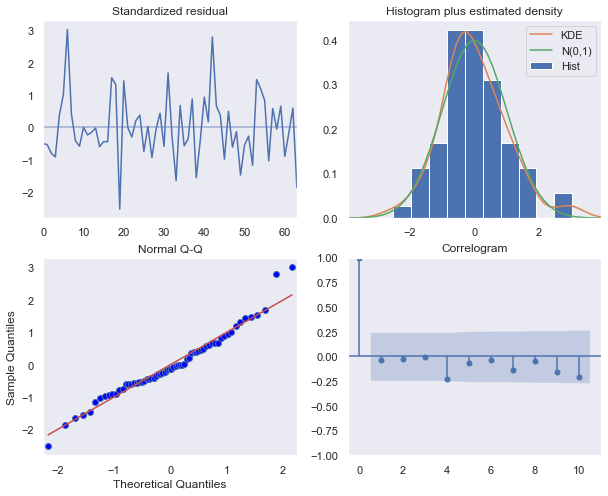

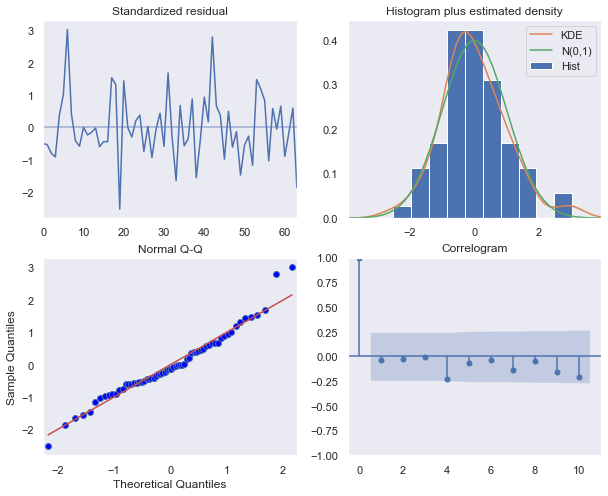

In [146]:
model.plot_diagnostics()